In [120]:
import pickle
import sklearn
import modAL
from modAL.models import ActiveLearner
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from modAL.uncertainty import uncertainty_sampling
import sys
import os

import audio_decryption
import IPython.display

# 1. Read negative file into test and train #

In [5]:
neg_file= open("/scratch/yw3004/sonyc/sonyc_distortion_classification/data/negative_xy_new.pickle", "rb")
negative_xy = pickle.load(neg_file)

In [8]:
negative_xy

array([['146', '14', '129', ..., '255', '0', 'b827eb4e7821'],
       ['154', '30', '171', ..., '255', '0', 'b827eb4e7821'],
       ['153', '25', '150', ..., '255', '0', 'b827eb4e7821'],
       ...,
       ['153', '25', '146', ..., '255', '0', 'b827eb9bed23'],
       ['153', '25', '152', ..., '255', '0', 'b827eb9bed23'],
       ['155', '23', '168', ..., '255', '0', 'b827eb429cd4']],
      dtype='<U21')

In [9]:
sens= []
for i in range(negative_xy.shape[0]):
    sens.append(negative_xy[i,-1])

In [10]:
unique_sensors = np.unique(sens)

In [11]:
unique_sensors

array(['b827eb0d8af7', 'b827eb0fedda', 'b827eb122f0f', 'b827eb1685c7',
       'b827eb2a1bce', 'b827eb429cd4', 'b827eb42bd4a', 'b827eb44506f',
       'b827eb4e7821', 'b827eb5895e9', 'b827eb815321', 'b827eb86d458',
       'b827eb8e2420', 'b827eb9bed23', 'b827ebad073b'], dtype='<U12')

In [12]:
negative_test = np.zeros((7*20,negative_xy.shape[1]-1))
negative_train = np.zeros((8*20,negative_xy.shape[1]-1))
j=0
k=0
for i in range(negative_xy.shape[0]):
    
    if negative_xy[i,-1]=='b827eb0d8af7' or negative_xy[i,-1]=='b827eb0fedda' or negative_xy[i,-1]=='b827eb122f0f' or negative_xy[i,-1]=='b827eb1685c7' or negative_xy[i,-1]=='b827eb2a1bce'or negative_xy[i,-1]=='b827eb429cd4' or negative_xy[i,-1]=='b827eb42bd4a':
        negative_test[j,:]= negative_xy[i,:-1]
        j=j+1
    else:
        negative_train[k,:]= negative_xy[i,:-1]
        k=k+1 

In [13]:
negative_train = negative_train.astype(int)

In [14]:
negative_train

array([[146,  14, 129, ...,  62, 255,   0],
       [154,  30, 171, ..., 158, 255,   0],
       [153,  25, 150, ..., 150, 255,   0],
       ...,
       [158,  29, 166, ...,  87, 255,   0],
       [153,  25, 146, ...,   0, 255,   0],
       [153,  25, 152, ...,   0, 255,   0]])

In [15]:
negative_test = negative_test.astype(int)

In [16]:
negative_test

array([[152,  24, 142, ...,  30, 255,   0],
       [162,  34, 157, ..., 255, 255,   0],
       [154,  28, 152, ..., 129, 255,   0],
       ...,
       [156,  25, 180, ...,   7, 255,   0],
       [153,  28, 170, ..., 124, 255,   0],
       [155,  23, 168, ...,  90, 255,   0]])

# 2. Read positive file into test and train #

In [17]:
positive_xy = pickle.load(open( "/scratch/yw3004/sonyc/sonyc_distortion_classification/data/positive_xy_new.pickle", "rb" ))

In [18]:
positive_xy

array([['153', '17', '128', ..., '255', '1', 'b827eb429cd4'],
       ['150', '19', '127', ..., '255', '1', 'b827eb429cd4'],
       ['155', '18', '126', ..., '255', '1', 'b827eb429cd4'],
       ...,
       ['160', '20', '161', ..., '255', '1', 'b827eb42bd4a'],
       ['154', '20', '139', ..., '255', '1', 'b827eb42bd4a'],
       ['154', '21', '130', ..., '255', '1', 'b827eb42bd4a']],
      dtype='<U21')

In [19]:
positive_test = np.zeros((7*20,positive_xy.shape[1]-1))
positive_train = np.zeros((8*20,positive_xy.shape[1]-1))
j=0
k=0
for i in range(positive_xy.shape[0]):
    
    if positive_xy[i,-1]=='b827eb0d8af7' or positive_xy[i,-1]=='b827eb0fedda' or positive_xy[i,-1]=='b827eb122f0f' or positive_xy[i,-1]=='b827eb1685c7' or positive_xy[i,-1]=='b827eb2a1bce'or positive_xy[i,-1]=='b827eb429cd4' or positive_xy[i,-1]=='b827eb42bd4a':
        positive_test[j,:]= positive_xy[i,:-1]
        j=j+1
    else:
        positive_train[k,:]= positive_xy[i,:-1]
        k=k+1 

In [20]:
positive_train = positive_train.astype(int)

In [21]:
positive_train

array([[152,   7, 152, ..., 200, 255,   1],
       [151,  12, 155, ...,  87, 255,   1],
       [155,  17, 160, ...,   0, 255,   1],
       ...,
       [153,  22, 143, ..., 202, 255,   1],
       [157,  14, 162, ..., 163, 255,   1],
       [152,  21, 140, ..., 243, 255,   1]])

In [22]:
positive_test = positive_test.astype(int)

In [23]:
positive_test

array([[153,  17, 128, ..., 136, 255,   1],
       [150,  19, 127, ...,  76, 255,   1],
       [155,  18, 126, ..., 156, 255,   1],
       ...,
       [160,  20, 161, ..., 167, 255,   1],
       [154,  20, 139, ..., 255, 255,   1],
       [154,  21, 130, ..., 137, 255,   1]])

# 3. Concatenate negatives and positives in both test and train #

## 3.1. Concatenate train examples together ##

In [24]:
train = np.concatenate((positive_train, negative_train))

In [25]:
train

array([[152,   7, 152, ..., 200, 255,   1],
       [151,  12, 155, ...,  87, 255,   1],
       [155,  17, 160, ...,   0, 255,   1],
       ...,
       [158,  29, 166, ...,  87, 255,   0],
       [153,  25, 146, ...,   0, 255,   0],
       [153,  25, 152, ...,   0, 255,   0]])

## 3.2. Concatenate test examples together ##

In [26]:
test = np.concatenate((positive_test, negative_test))

In [27]:
test

array([[153,  17, 128, ..., 136, 255,   1],
       [150,  19, 127, ...,  76, 255,   1],
       [155,  18, 126, ..., 156, 255,   1],
       ...,
       [156,  25, 180, ...,   7, 255,   0],
       [153,  28, 170, ..., 124, 255,   0],
       [155,  23, 168, ...,  90, 255,   0]])

## 3.3. Shuffle data ##

In [28]:
np.random.shuffle(train)

In [29]:
np.random.shuffle(test)

## 3.4. Separate x and y ##

### 3.4.1. Separate training data ###

In [30]:
x_train = train[:,:-1]

In [31]:
x_train.shape

(320, 128)

In [32]:
y_train = train[:,-1]

In [33]:
y_train.shape

(320,)

### 3.4.2. Separate test data ###

In [34]:
x_test = test[:,:-1]

In [35]:
x_test.shape

(280, 128)

In [36]:
y_test = test[:,-1]

In [37]:
y_test.shape

(280,)

# 4. Read X_pool file #

In [124]:
pool_file= open("/scratch/yw3004/sonyc/sonyc_distortion_classification/data/X_pool_100000.pickle", "rb")
pool = pickle.load(pool_file)

In [125]:
pool.shape

(100000, 132)

In [126]:
X_pool = pool[:, :128]
X_pool = X_pool.astype(int)

In [129]:
info_pool = pool[:, 128:]

# 5. Create classifier #

In [131]:
clf = RandomForestClassifier(n_estimators = 100)

In [132]:
clf.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [133]:
pred = clf.predict(x_test)

In [134]:
sklearn.metrics.accuracy_score(y_test,pred)

0.9571428571428572

# 6. Create Active Learner #

In [135]:
learner = ActiveLearner(
    estimator=clf,
    query_strategy=uncertainty_sampling,
    X_training=x_train, y_training=y_train
)

In [128]:
#set audio_path
audio_path_1 = '/beegfs/work/sonyc/audio/'
audio_path_2 = '/scratch/work/sonyc/data/audio/'

#set **kwargs


In [137]:
n_queries = 3
n_instances = 2
accuracy = np.zeros(n_queries)
not_converged = True
count = 0
while not_converged:
    y = []
    query_idx, query_instance = learner.query(X_pool, n_instances=n_instances)
    print (query_idx)
    for i in range(n_instances):
        sensor_id = info_pool[query_idx[i]][0]
        timestamp = info_pool[query_idx[i]][1]
        frame = int(info_pool[query_idx[i]][2])
        filepath = info_pool[query_idx[i]][3]
        
        try:
            decrypt_path = os.path.join(audio_path_1, filepath.split('/')[-2], filepath.split('/')[-1])
            IPython.display.display(audio_decryption.decrypt_and_load_audio(decrypt_path, 
                                                                            sensor_id,
                                                                            timestamp, 
                                                                            sample_rate=44100, 
                                                                            frame=frame, 
                                                                            **kwargs))

        except FileNotFoundError:
            decrypt_path = os.path.join(audio_path_2, filepath.split('/')[-2], filepath.split('/')[-1]+'.gz')
            IPython.display.display(audio_decryption.decrypt_and_load_audio(decrypt_path, 
                                                                            sensor_id,
                                                                            timestamp, 
                                                                            sample_rate=44100, 
                                                                            frame=frame, 
                                                                            **kwargs))
                                    
        
        y_new = input("Please input label for\nsensor_id = '%s'\ntimestamp = %s\nframe = %d (1 if noise is present, 0 if noise is not present)" % (sensor_id,timestamp,frame))
        y.append(int(y_new))
        
    print('ARRAY: ',y)
    learner.teach(
        X=X_pool[query_idx],
        y=np.array(y).reshape(-1, ))
    
    X_pool = np.delete(X_pool, query_idx, axis=0)
    info_pool = np.delete(info_pool, query_idx, axis=0)
    
    print('Accuracy after query no. %d: %f' % (count+1, learner.score(x_test, y_test)))
    
    accuracy[count]=learner.score(x_test, y_test)
    
    print(accuracy[count]-accuracy[count-1])
    #(accuracy[count]>=accuracy[count-1] and accuracy[count]-accuracy[count-1]<0.0001) or 
    if count == n_queries-1:
        not_converged = False
    count = count +1
print(accuracy)

In [90]:
import matplotlib.pyplot as plt

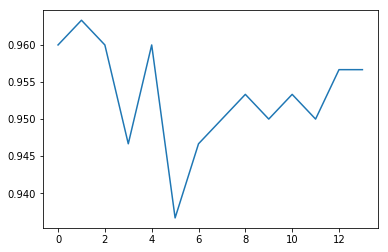

In [95]:
acc=[]
for i in range(len(accuracy)):
    if accuracy[i] > 0:
        acc.append(accuracy[i])

plt.plot(acc)
plt.show()